In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
!pip install git+https://github.com/tensorflow/examples.git

  Cloning https://github.com/tensorflow/examples.git to /tmp/pip-req-build-3i_omcn4
  Running command git clone -q https://github.com/tensorflow/examples.git /tmp/pip-req-build-3i_omcn4
  Created wheel for tensorflow-examples: filename=tensorflow_examples-ad3ab9b65e67459172077d13acb5f7da83cabd80_-py3-none-any.whl size=270996 sha256=e750dcb4b7d6faddd40a1628e4f3f8e2caa857c10be7012a947e7a68f6eb07e5
  Stored in directory: /tmp/pip-ephem-wheel-cache-vjmnj_5a/wheels/eb/19/50/2a4363c831fa12b400af86325a6f26ade5d2cdc5b406d552ca
Failed to build tensorflow-examples
    Running setup.py install for tensorflow-examples ... done
  DEPRECATION: tensorflow-examples was installed using the legacy 'setup.py install' method, because a wheel could not be built for it. A possible replacement is to fix the wheel build issue reported above. You can find discussion regarding this at https://github.com/pypa/pip/issues/8368.


In [47]:
import tensorflow as tf
import os
import numpy as np
from tensorflow.keras.preprocessing.image import load_img, img_to_array
import time
import matplotlib.pyplot as plt
from IPython.display import clear_output
from tensorflow_examples.models.pix2pix import pix2pix

AUTOTUNE = tf.data.AUTOTUNE

In [ ]:
dataset = np.load('drive/MyDrive/Summer_internships/Transfert/Datasets/Compressed/train_128.npz')

In [ ]:
train_th, train_vis = dataset['arr_0'], dataset['arr_1']

In [ ]:
print(train_th.shape, train_vis.shape)

(900, 128, 128, 3) (900, 128, 128, 3)


In [ ]:
th_dataset = tf.data.Dataset.from_tensor_slices(train_th)

In [ ]:
vis_dataset = tf.data.Dataset.from_tensor_slices(train_vis)

In [ ]:
th_dataset.element_spec

TensorSpec(shape=(128, 128, 3), dtype=tf.float32, name=None)

In [ ]:
BUFFER_SIZE = 900
BATCH_SIZE = 1

In [ ]:
# x_th = th_dataset.shuffle(
#         BUFFER_SIZE).batch(BATCH_SIZE)

# x_vis = vis_dataset.shuffle(
#       BUFFER_SIZE).batch(BATCH_SIZE)

In [ ]:
def normalize_image(im):
  return (im - 127.5) / 127.5

In [ ]:
x_th = th_dataset.cache().map(
    normalize_image, num_parallel_calls=AUTOTUNE).shuffle(
        BUFFER_SIZE).batch(BATCH_SIZE)

x_vis = vis_dataset.cache().map(
    normalize_image, num_parallel_calls=AUTOTUNE).shuffle(
        BUFFER_SIZE).batch(BATCH_SIZE)

In [ ]:
sample_th = next(iter(x_th))
sample_vis = next(iter(x_vis))

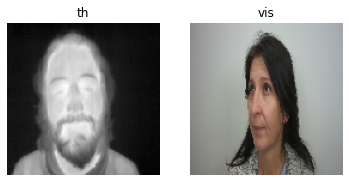

In [ ]:
plt.subplot(121)
plt.title('th')
plt.axis('off')
plt.imshow((sample_th[0] + 1) / 2.0)

plt.subplot(122)
plt.title('vis')
plt.axis('off')
plt.imshow((sample_vis[0] + 1) / 2.0)

###building the model

In [ ]:
!pip install tensorflow-addons

     |████████████████████████████████| 679 kB 7.3 MB/s 


In [ ]:
from numpy import load, zeros, ones
from numpy.random import randint
import tensorflow_addons as tfa
from tensorflow.keras.optimizers import Adam
from tensorflow.keras import Model
from tensorflow.keras import Input
from tensorflow.keras.layers import Add
from tensorflow.keras.layers import Conv2D
from tensorflow.keras.layers import Dropout
from tensorflow.keras.layers import LeakyReLU
from tensorflow.keras.layers import Activation
from tensorflow.keras.layers import Concatenate
from tensorflow.keras.layers import Conv2DTranspose
from tensorflow.keras.layers import BatchNormalization
from tensorflow.keras.initializers import RandomNormal

In [ ]:
def discriminator_model(in_shape=(128, 128, 3)):
  #weights initialization
  init = RandomNormal(stddev=.02)
  #input layers
  in_src_im = Input(shape=in_shape)
  in_tar_im = Input(shape=in_shape)
  #concatenate inputs
  merged = Concatenate()([in_src_im, in_tar_im])

  d = Conv2D(64, (4, 4), strides=(2, 2), padding='same', kernel_initializer=init)(merged)
  d = LeakyReLU(alpha=0.2)(d)

  d = Conv2D(128, (4,4), strides=(2,2), padding='same', kernel_initializer=init)(d)
  d = tfa.layers.InstanceNormalization()(d)
  d = LeakyReLU(alpha=0.2)(d)

  d = Conv2D(256, (4,4), strides=(2,2), padding='same', kernel_initializer=init)(d)
  d = tfa.layers.InstanceNormalization()(d)
  d = LeakyReLU(alpha=0.2)(d)

  d = Conv2D(512, (4,4), strides=(2,2), padding='same', kernel_initializer=init)(d)
  d = tfa.layers.InstanceNormalization()(d)
  d = LeakyReLU(alpha=0.2)(d)

  #patch output
  d = Conv2D(1, (4, 4), padding='same', kernel_initializer=init)(d)
  patch_out = Activation('sigmoid')(d)

  model = Model([in_src_im, in_tar_im], patch_out)
  return model

In [ ]:
def encoder_block(n_filters, input_layer, s1=(2, 2), s2=(1, 1) ,batch_norm=True):
  init = RandomNormal(stddev=0.02)
  if batch_norm:
    x = tfa.layers.InstanceNormalization()(input_layer)
    x = Activation('relu')(x)
    x = Conv2D(n_filters, (3, 3), strides=s1, padding='same', kernel_initializer=init)(x)
  else:
    x = Conv2D(n_filters, (3, 3), strides=s1, padding='same', kernel_initializer=init)(input_layer)

  x = tfa.layers.InstanceNormalization()(x)
  x = Activation('relu')(x)
  x = Conv2D(n_filters, (3, 3), strides=s2, padding='same', kernel_initializer=init)(x)
  
  alt = Conv2D(n_filters, (1, 1), strides=s1, padding='same', kernel_initializer=init)(input_layer)
  alt = tfa.layers.InstanceNormalization()(alt)

  x = Add()([x, alt])
  return x

In [ ]:
def decoder_block(n_filters, input_layer, skip):
  init = RandomNormal(stddev=0.02)
  x = Conv2DTranspose(n_filters, (3, 3), strides=(2, 2), padding='same', kernel_initializer=init)(input_layer)
  g = Concatenate()([x, skip])
  x = tfa.layers.InstanceNormalization()(g)
  x = Activation('relu')(x)
  x = Conv2D(n_filters, (3, 3), strides=(1, 1), padding='same', kernel_initializer=init)(x)
  x = tfa.layers.InstanceNormalization()(x)
  x = Activation('relu')(x)
  x = Conv2D(n_filters, (3, 3), strides=(1, 1), padding='same', kernel_initializer=init)(x)

  alt = Conv2D(n_filters, (1, 1), strides=(1, 1), padding='same', kernel_initializer=init)(g)
  alt = tfa.layers.InstanceNormalization()(alt)

  x = Add()([x, alt])
  return x

In [ ]:
def generator128(image_shape=(128, 128, 3)):
  init = RandomNormal(stddev=0.02)
  #encoding
  in_layer = Input(shape=image_shape)
  e1 = encoder_block(64, in_layer, s1=(1, 1), s2=(1, 1) ,batch_norm=False)
  e2 = encoder_block(128, e1)
  e3 = encoder_block(256, e2)

  #bridge
  x = tfa.layers.InstanceNormalization()(e3)
  x = Activation('relu')(x)
  x = Conv2D(256, (3, 3), strides=(2, 2), padding='same', kernel_initializer=init)(x)
  x = tfa.layers.InstanceNormalization()(x)
  x = Activation('relu')(x)
  x = Conv2D(256, (3, 3), strides=(1, 1), padding='same', kernel_initializer=init)(x)

  alt = Conv2D(256, (1, 1), strides=(2, 2), padding='same', kernel_initializer=init)(e3)
  alt = tfa.layers.InstanceNormalization()(alt)

  x = Add()([alt, x])

  #decoding
  d1 = decoder_block(256, x, e3)
  d2 = decoder_block(128, d1, e2)
  d3 = decoder_block(64, d2, e1)

  #output
  g = Conv2D(3, (1, 1), padding='same', kernel_initializer=init)(d3)
  out_layer = Activation('tanh')(g)
  model = Model(in_layer, out_layer) 
  return model

In [ ]:
def generator256(image_shape=(256, 256, 3)):
  init = RandomNormal(stddev=0.02)
  #encoding
  in_layer = Input(shape=image_shape)
  e1 = encoder_block(64, in_layer, s1=(1, 1), s2=(1, 1) ,batch_norm=False)
  e2 = encoder_block(128, e1)
  e3 = encoder_block(256, e2)
  e4 = encoder_block(512, e3)

  #bridge
  x = BatchNormalization()(e4)
  x = Activation('relu')(x)
  x = Conv2D(512, (3, 3), strides=(2, 2), padding='same', kernel_initializer=init)(x)
  x = BatchNormalization()(x)
  x = Activation('relu')(x)
  x = Conv2D(512, (3, 3), strides=(1, 1), padding='same', kernel_initializer=init)(x)

  alt = Conv2D(512, (1, 1), strides=(2, 2), padding='same', kernel_initializer=init)(e4)
  alt = BatchNormalization()(alt)
  x = Add()([alt, x])

  #decoding
  d0 = decoder_block(512, x, e4)
  d1 = decoder_block(256, d0, e3)
  d2 = decoder_block(128, d1, e2)
  d3 = decoder_block(64, d2, e1)

  #output
  g = Conv2D(3, (1, 1), padding='same', kernel_initializer=init)(d3)
  out_layer = Activation('tanh')(g)
  model = Model(in_layer, out_layer) 
  return model

In [ ]:
gen_th = generator128()
gen_vis = generator128()

# disc_th = discriminator_model()
# disc_vis = discriminator_model()

disc_th = pix2pix.discriminator(norm_type='instancenorm', target=False)
disc_vis = pix2pix.discriminator(norm_type='instancenorm', target=False)

In [ ]:
tf.keras.utils.plot_model(disc_th, 'disc.png', show_shapes=True, show_dtype=True)

###Loss functions

In [ ]:
LAMBDA = 10

loss_obj = tf.keras.losses.BinaryCrossentropy(from_logits=True)

In [ ]:
def disc_loss(real, gen):
  real_loss = loss_obj(tf.ones_like(real), real)
  gen_loss = loss_obj(tf.zeros_like(gen), gen)
  total_loss = real_loss + gen_loss
  return total_loss * 0.5

In [ ]:
def gen_loss(gen):
  return loss_obj(tf.ones_like(gen), gen)

In [ ]:
def cycle_loss(real_im, cycled_im):
  loss = tf.reduce_mean(tf.abs(real_im - cycled_im))
  return LAMBDA * loss

In [ ]:
def identity_loss(real_im, same_im):
  loss = tf.reduce_mean(tf.abs(real_im - same_im))
  return LAMBDA * 0.5 * loss

###Initialize optimizers

In [ ]:
gen_th_opt = tf.keras.optimizers.Adam(2e-4, beta_1=0.5)
gen_vis_opt = tf.keras.optimizers.Adam(2e-4, beta_1=0.5)

disc_th_opt = tf.keras.optimizers.Adam(2e-4, beta_1=0.5)
disc_vis_opt = tf.keras.optimizers.Adam(2e-4, beta_1=0.5)

###checkpoint

In [ ]:
check_path = 'drive/MyDrive/CycleGAN6'

ckpt = tf.train.Checkpoint(gen_th=gen_th,
                           gen_vis=gen_vis,
                           disc_th=disc_th,
                           disc_vis=disc_vis,
                           gen_th_opt=gen_th_opt,
                           gen_vis_opt=gen_vis_opt,
                           disc_th_opt=disc_th_opt,
                           disc_vis_opt=disc_vis_opt)

ckpt_manager = tf.train.CheckpointManager(ckpt, check_path, max_to_keep=5)

#if a checkpoint exists, restore the latest checkpoint.
if ckpt_manager.latest_checkpoint:
  ckpt.restore(ckpt_manager.latest_checkpoint)
  print('Latest checkpoint restored!')

Latest checkpoint restored!


###Train

In [ ]:
EPOCHS = 85

In [ ]:
def generate_images(model, test_input):
  prediction = model(test_input)

  plt.figure(figsize=(12, 12))

  display_list = [(test_input[0] + 1 / 2.0), prediction[0]]
  title = ['Input Image', 'Predicted Image']

  for i in range(2):
    plt.subplot(1, 2, i+1)
    plt.title(title[i])
    # getting the pixel values between [0, 1]
    plt.imshow(display_list[i] * 0.5 + 0.5)
    plt.axis('off')
  plt.show()

training loop consists of four basic steps:

* Get the predictions.
* Calculate the loss.
* Calculate the gradients using backpropagation.
* Apply the gradients to the optimizer.

In [ ]:
@tf.function
def train_step(real_th, real_vis):
    # persistent is set to True because the tape is used more than
    # once to calculate the gradients.
  with tf.GradientTape(persistent=True) as tape:
    fake_vis = gen_vis(real_th, training=True)
    cycled_th = gen_th(fake_vis, training=True)

    fake_th = gen_th(real_vis, training=True)
    cycled_vis = gen_vis(fake_th, training=True)

    #same_ used for identity loss.
    same_th = gen_th(real_th, training=True)
    same_vis = gen_vis(real_vis, training=True)

    disc_real_th = disc_th(real_th, training=True)
    disc_real_vis = disc_vis(real_vis, training=True)

    disc_fake_th = disc_th(fake_th, training=True)
    disc_fake_vis = disc_vis(fake_vis, training=True)

    #calculate loss
    gen_vis_loss = gen_loss(disc_fake_vis)
    gen_th_loss = gen_loss(disc_fake_th)

    total_cycle_loss = cycle_loss(real_th, cycled_th) + cycle_loss(real_vis, cycled_vis)

    #Total generator loss = adversarial loss + cycle loss
    tot_gen_th_loss = gen_th_loss + total_cycle_loss + identity_loss(real_th, same_th)
    tot_gen_vis_loss = gen_vis_loss + total_cycle_loss + identity_loss(real_vis, same_vis)

    disc_th_loss = disc_loss(disc_real_th, disc_fake_th)
    disc_vis_loss = disc_loss(disc_real_vis, disc_fake_vis)

    #calculate the gradients for generator and discriminator
    gen_th_grads = tape.gradient(tot_gen_th_loss, 
                                gen_th.trainable_variables)
    gen_vis_grads = tape.gradient(tot_gen_vis_loss, 
                                gen_vis.trainable_variables)

    disc_th_grads = tape.gradient(disc_th_loss, 
                                disc_th.trainable_variables)
    disc_vis_grads = tape.gradient(disc_vis_loss, 
                                disc_vis.trainable_variables)
    
    #apply the gradients to the optimizer
    gen_th_opt.apply_gradients(zip(gen_th_grads, gen_th.trainable_variables))
    gen_vis_opt.apply_gradients(zip(gen_vis_grads, gen_vis.trainable_variables))
    
    disc_th_opt.apply_gradients(zip(disc_th_grads, disc_th.trainable_variables))
    disc_vis_opt.apply_gradients(zip(disc_vis_grads, disc_vis.trainable_variables))

#####do not forget to update paths before executing following cells 

.........

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


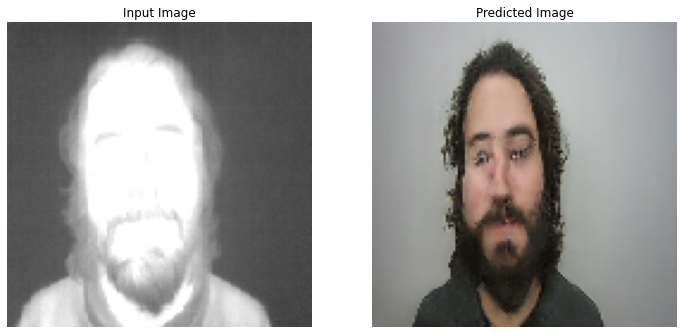

Time taken for epoch 1 is 234.46050906181335 sec

.........

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


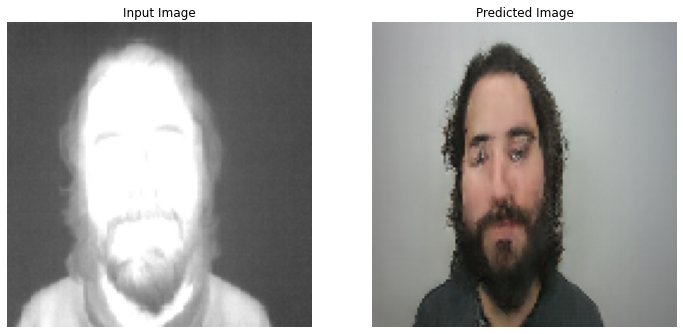

Time taken for epoch 2 is 170.92951655387878 sec

.........

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


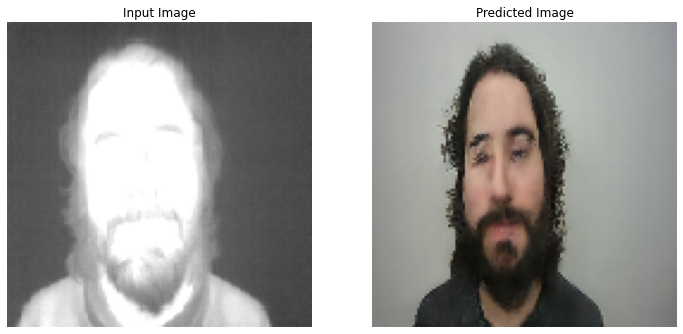

Time taken for epoch 3 is 170.72994899749756 sec

.........

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


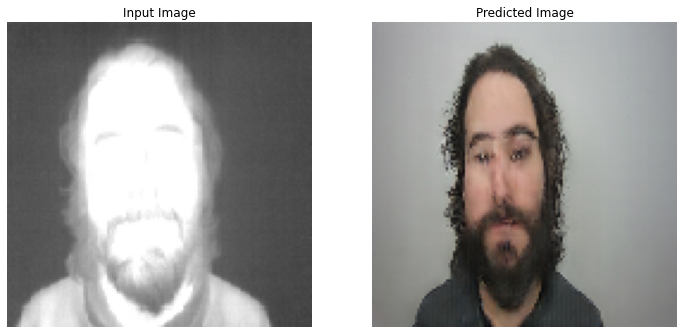

Time taken for epoch 4 is 170.81647300720215 sec

.........

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


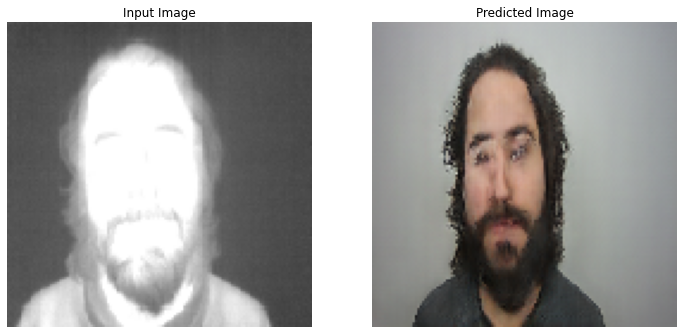

Saving checkpoint for epoch 5 at drive/MyDrive/CycleGAN6/ckpt-17
Time taken for epoch 5 is 171.87336254119873 sec

.........

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


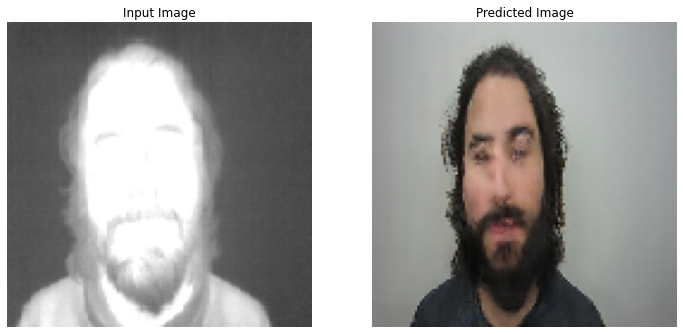

Time taken for epoch 6 is 170.78717923164368 sec

.........

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


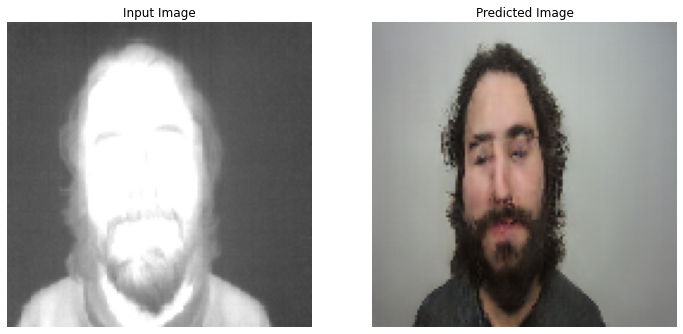

Time taken for epoch 7 is 170.91716527938843 sec

.........

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


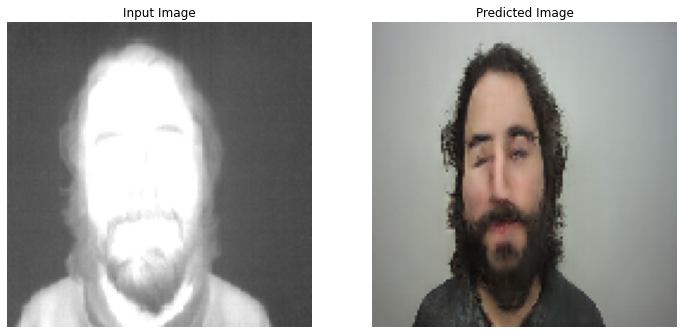

Time taken for epoch 8 is 171.02474784851074 sec

.........

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


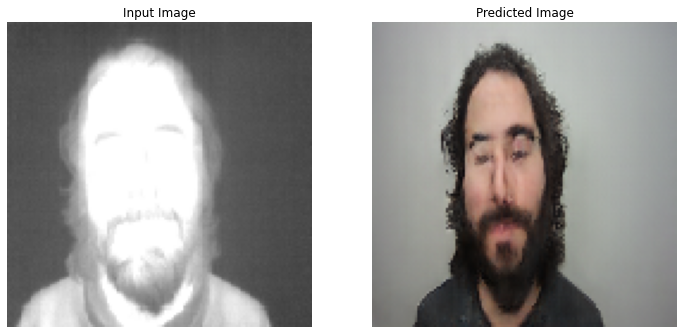

Time taken for epoch 9 is 170.53065037727356 sec

.........

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


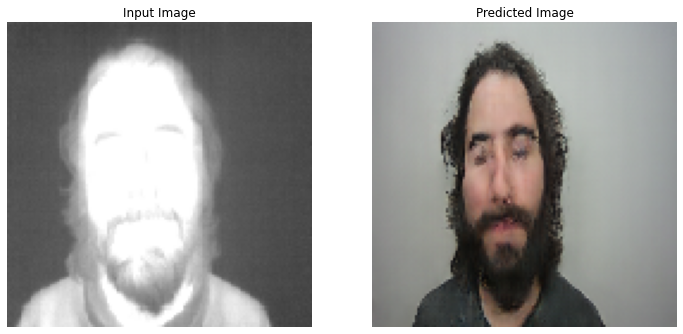

Saving checkpoint for epoch 10 at drive/MyDrive/CycleGAN6/ckpt-18
Time taken for epoch 10 is 172.3854694366455 sec

.........

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


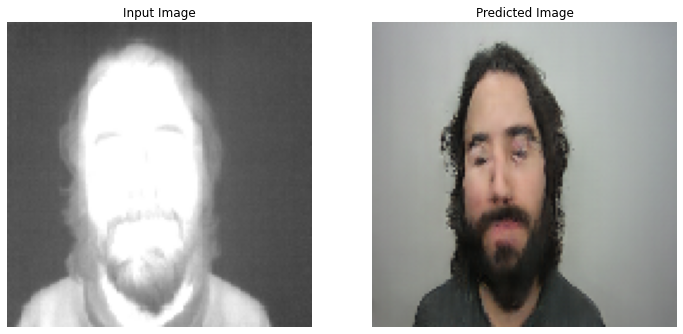

Time taken for epoch 11 is 171.12205696105957 sec



In [ ]:
for epoch in range(EPOCHS):
  start = time.time()

  n = 0
  for th_im, vis_im in tf.data.Dataset.zip((x_th, x_vis)):
    train_step(th_im, vis_im)
    if n % 100 == 0:
      print('.', end='')
    n += 1

  #clear_output(wait=True)
  ## using a sample image so that the progress of the model is clearly visible
  generate_images(gen_vis, sample_th)

  if (epoch + 1) % 5 == 0:
    ckpt_save_path = ckpt_manager.save() 
    print ('Saving checkpoint for epoch {} at {}'.format(epoch+1,
                                                         ckpt_save_path))

  print ('Time taken for epoch {} is {} sec\n'.format(epoch + 1,
                                                      time.time()-start))

In [ ]:
gen_vis.save('drive/MyDrive/CycleGAN6/g_cycleGAN6.h5')

###Testing the generator

In [43]:
data_path = 'drive/MyDrive/Summer_internships/Transfert/Datasets/VIS-TH-8bits'

In [ ]:
#loading saved generator
model = tf.keras.models.load_model('drive/MyDrive/CycleGAN6/g_cycleGAN6.h5', compile=False)

In [40]:
def load_test_data(data_path):
  y = ['038', '013', '015', '003', '033']
  y.sort()
  y = [ os.path.join(data_path, i, 'TH') for i in y]
  im_path = []
  im_name = []
  for x in y:
    for i in os.listdir(x):
      #skipping dark images
      if i.find('20_LD') != -1:
        continue
      else:
        im_path.append(os.path.join(x, i))
        im_name.append(i)
  im_name = [ i.replace('tiff', 'jpg') for i in im_name]
  im_name = [ i.replace('TH', 'VIS') for i in im_name]
  return im_path, im_name

In [41]:
#load, predict and save result
def generate_data(image_path, image_name):
  res_dir = 'drive/MyDrive/Summer_internships/Transfert/Results/CycleGAN/ResUnet6/'
  for i in range(len(image_path)):
    #read image
    im = load_img(image_path[i], target_size=(128,128)) 
    im = img_to_array(im)
    #scale image tp [-1, 1]
    im = (im - 127.5) / 127.5
    im = np.expand_dims(im, axis=0)
    #predict
    pred = model.predict(im)
    #rescale image to [0, 1]
    pred = (pred + 1) / 2.0
    try:
      tf.keras.preprocessing.image.save_img(res_dir + image_name[i], pred[0], scale=True)
    except:
      print('error saving image please verify the path!')

In [48]:
im_path, im_name = load_test_data(data_path)

In [49]:
#generate_data(im_path, im_name)